# Logistic Regression and SVMs (Modeling)

# Content

* [1. Create Models](#Create-Models)
    - [Data Importing and Cleaning](#Data-Importing-and-Cleaning)
    - [Logistic Regression](#Logistic-Regression)
    - [Support Vector Machine](#Support-Vector-Machine)
* [2. Model Advantages](#Model-Advantages)
    - [Does one type of model offer superior performance over another in terms of prediction accuracy?](#question4)
    - [In terms of training time or efficiency?](#question5)
* [3. Interpret Feature importance](#Interpret-Feature-Importance)
    - [Given the coefficients of each feature, why do you think some features are more important?](#question1)
* [4. Interpret Support Vectors](#Interpret-Support-Vectors)
    - [Do the chosen support vectors provide any insight into the data?](#question2)

  # 1. Create Models<a id='Create-Models'/>

## Data Importing and Cleaning
- This is the condensed version of our data cleaning, to see the document with explanation. You can go to the following link: https://github.com/olmosjorge28/DS7331_ML1_ASSINGMENTS/blob/main/lab1/Lab_1_notebook.html

In [113]:
import pandas as pd
import numpy as np

hotel_bookings = pd.read_csv('https://raw.githubusercontent.com/olmosjorge28/DS7331_ML1_ASSINGMENTS/main/hotel_bookings.csv') # read in the csv file
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/15


In [114]:
import math
from datetime import date


hotel_bookings_transform = hotel_bookings
hotel_bookings_transform= hotel_bookings_transform.drop(columns=['agent','company', 'country'])

hotel_bookings_transform['meal']= hotel_bookings_transform['meal'].apply(lambda x: 'SC' if  x == 'Undefined'  else x)
hotel_bookings_transform['children']= hotel_bookings_transform['children'].apply(lambda x: 0 if  math.isnan(x)  else x)
hotel_bookings_transform['market_segment']= hotel_bookings_transform['market_segment'].apply(lambda x: 'Online TA' if  x == 'Undefined'  else x)
hotel_bookings_transform['distribution_channel']= hotel_bookings_transform['distribution_channel'].apply(lambda x: 'TA/TO' if  x == 'Undefined'  else x)


hotel_bookings_transform['hotel']=hotel_bookings_transform['hotel'].astype('category').cat.codes
hotel_bookings_transform['market_segment']=hotel_bookings_transform['market_segment'].astype('category').cat.codes
hotel_bookings_transform['meal']=hotel_bookings_transform['meal'].astype('category').cat.codes
hotel_bookings_transform['reservation_status']=hotel_bookings_transform['reservation_status'].astype('category').cat.codes
hotel_bookings_transform['distribution_channel']=hotel_bookings_transform['distribution_channel'].astype('category').cat.codes
hotel_bookings_transform['reserved_room_type']=hotel_bookings_transform['reserved_room_type'].astype('category').cat.codes
hotel_bookings_transform['assigned_room_type']=hotel_bookings_transform['assigned_room_type'].astype('category').cat.codes
hotel_bookings_transform['deposit_type']=hotel_bookings_transform['deposit_type'].astype('category').cat.codes
hotel_bookings_transform['customer_type']=hotel_bookings_transform['customer_type'].astype('category').cat.codes

assign_month = {"arrival_date_month": {"January": 1, "February": 2, "March": 3, "April": 4,"May": 5,"June": 6,"July": 7,"August": 8,"September": 9,"October": 10,"November": 11,"December": 12}}
hotel_bookings_transform = hotel_bookings_transform.replace(assign_month)

# Convert Date to Ordinal
import datetime as dt
hotel_bookings_transform['reservation_status_date'] = pd.to_datetime(hotel_bookings_transform['reservation_status_date'])
hotel_bookings_transform['reservation_status_date'] = hotel_bookings_transform['reservation_status_date'].map(dt.datetime.toordinal)

hotel_bookings_transform=hotel_bookings_transform.assign(booking_day_of_year = hotel_bookings_transform["arrival_date_year"].astype(str) + '-' + 
hotel_bookings_transform["arrival_date_month"].astype(str) + '-' +hotel_bookings_transform["arrival_date_day_of_month"].astype(str))
hotel_bookings_transform['booking_day_of_year']=pd.to_datetime(hotel_bookings_transform.booking_day_of_year)
hotel_bookings_transform['booking_day_of_year']=hotel_bookings_transform['booking_day_of_year'].map(lambda x: x.toordinal() - date(x.year, 1, 1).toordinal() + 1)


hotel_bookings_transform=hotel_bookings_transform.drop(columns=['arrival_date_year','reservation_status_date'])
#hotel_bookings_transform['booking_date']=hotel_bookings_transform['booking_date'].map(dt.datetime.toordinal)

### Normalization

- SVM tries to maximize the distance between the support vectors and the separating plane. 
- Prior to conducting SVM, we need to normalize the dataset so we can get rid of bias and dominance of certain features over others. 
- The result of applying normalized dataset will be having the same influence on the distance metric, thus boosting the accuracy of the model. 

In [115]:
X=hotel_bookings_transform.drop(columns=['is_canceled','reservation_status','meal'])
y=hotel_bookings_transform.is_canceled
columns = X.columns

In [116]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
scaler

scaler.mean_
scaler.scale_

X_scaled = pd.DataFrame(scaler.transform(X),columns=columns)

Verifying each feature has a mean of zero:

In [117]:
X_scaled.mean(axis=0)

hotel                            -2.148285e-13
lead_time                         3.358325e-16
arrival_date_month               -1.221612e-14
arrival_date_week_number          4.093983e-15
arrival_date_day_of_month        -9.159196e-16
stays_in_weekend_nights           3.928971e-14
stays_in_week_nights             -2.182022e-14
adults                            5.708995e-15
children                         -6.989886e-16
babies                            5.955017e-15
market_segment                    4.484909e-15
distribution_channel              2.185129e-14
is_repeated_guest                -3.493540e-14
previous_cancellations            1.741766e-14
previous_bookings_not_canceled   -1.286381e-15
reserved_room_type                1.246924e-13
assigned_room_type                9.462049e-14
booking_changes                  -7.015186e-14
deposit_type                      1.754553e-13
days_in_waiting_list             -1.846956e-14
customer_type                    -2.170149e-14
adr          

Verifying that the standard deviation should be 1:

In [118]:
X_scaled.std(axis=0)

hotel                             1.000004
lead_time                         1.000004
arrival_date_month                1.000004
arrival_date_week_number          1.000004
arrival_date_day_of_month         1.000004
stays_in_weekend_nights           1.000004
stays_in_week_nights              1.000004
adults                            1.000004
children                          1.000004
babies                            1.000004
market_segment                    1.000004
distribution_channel              1.000004
is_repeated_guest                 1.000004
previous_cancellations            1.000004
previous_bookings_not_canceled    1.000004
reserved_room_type                1.000004
assigned_room_type                1.000004
booking_changes                   1.000004
deposit_type                      1.000004
days_in_waiting_list              1.000004
customer_type                     1.000004
adr                               1.000004
required_car_parking_spaces       1.000004
total_of_sp

### Feature Selection 

#### Optimizing variable settings before running feature selection
- Identifying highly correlated variables(>0.7 by convention) and dropping them from dataframe before running RFE 
- Selecting best logistic regression parameters for RFE

Identifying highly correlated variables beforehand:

In [119]:
correlated_features = []
correlation_matrix = X_scaled.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            
            correlated_features.append([correlation_matrix.columns[j],colname])
            
            
print('Highly correlated feature pairs are: {}'.format(correlated_features))

Highly correlated feature pairs are: [['arrival_date_month', 'arrival_date_week_number'], ['market_segment', 'distribution_channel'], ['reserved_room_type', 'assigned_room_type'], ['arrival_date_month', 'booking_day_of_year'], ['arrival_date_week_number', 'booking_day_of_year']]


In [120]:
# Decided to drop the following features from the highly correlated pairs
X_scaled=X_scaled.drop(['distribution_channel', 'arrival_date_month','assigned_room_type','booking_day_of_year'], axis=1)

Since we will be using Logistic regression method for RFE, we will be running initial model to select the best LR parameters:

#### RFE Selection
Work cited : https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15

Here we're examining the plot of the categorical values of interest and looking at the optimal number of features using RandomForest:

In [121]:
# Using randomforest to run RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

rfc = RandomForestClassifier(random_state=10)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3), scoring='accuracy')
rfecv.fit(X_scaled, y)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=10), scoring='accuracy')

In [122]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 13


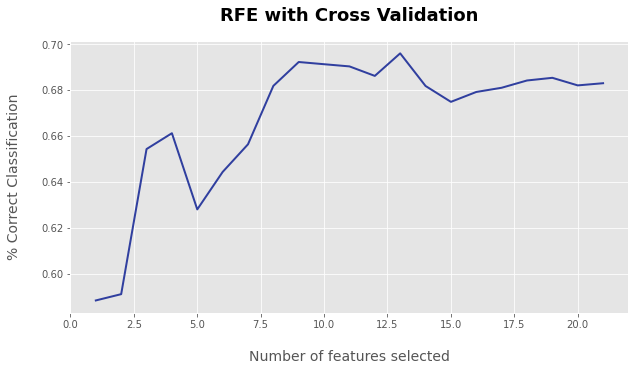

In [123]:
# Plotting RFE result

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title('RFE with Cross Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=2)

plt.show()

In [124]:
# Identifying which feature is Selected(= identified as True)

print(X_scaled.columns[np.where(rfecv.support_ == True)[0]])

Index(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'market_segment',
       'previous_cancellations', 'reserved_room_type', 'booking_changes',
       'deposit_type', 'customer_type', 'adr', 'total_of_special_requests'],
      dtype='object')


In [125]:
# Dropping those features that are identified as not important
X_sel=X_scaled[X_scaled.columns[np.where(rfecv.support_ == True)[0]]]

#### RFECV plot result
- A total of 13 features are selected based on random forest algorithm. 
    - lead_time,
    - deposit_type,
    - adr,
    - arrival_date_week_number,
    - arrival_date_day_of_month,
    - market_segment,
    - total_of_special_requests,
    - stays_in_week_nights,
    - previous_cancellations,
    - stays_in_weekend_nights,
    - customer_type,
    - reserved_room_type,
    - booking_changes

    
- As shown in the folloing RFECV plot, __lead_time__, __adr__ and __deposit_type__ are the three most important features.
- __arrival_date_week_number__, __arrival_date_day_of_month__,  __market_segment__, __total_of_special_request__, __stays_in_week_nights__, __previous_cancellations__ performed decent job. 
- __stays_in_weekend_nights__,__customer_type__,__reserved_room_type__, __booking_changes__ showed the least contribution to explaining the random forest model. 

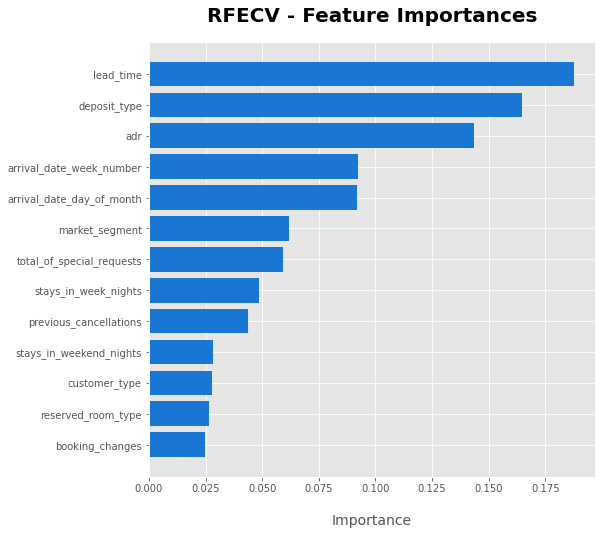

In [126]:
# Plotting features in the order of importance 

dset = pd.DataFrame()
dset['attr'] = X_sel.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)


plt.figure(figsize=(8, 8))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## Logistic Regression<a id='Logistic-Regression'/>

### Model 1 - Logistic regression (C=1.0)

In [127]:
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score

# Using cross validation, test/train split 80:20
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size= 0.2, random_state=10) 

for train_indices, test_indices in cv_object.split(X_sel,y): 
    X_train = X_sel.iloc[train_indices]
    y_train = y.iloc[train_indices]
    
    X_test = X_sel.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
logreg = LogisticRegression(random_state=10).fit(X_train,y_train)
logreg

print("Training set score: {:.3f}".format(logreg.score(X_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

import statsmodels.api as sm
logit_model=sm.Logit(y,X_sel)
result=logit_model.fit()
print(result.summary())

Training set score: 0.787
Test set score: 0.787
Optimization terminated successfully.
         Current function value: 0.483765
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               119390
Model:                          Logit   Df Residuals:                   119377
Method:                           MLE   Df Model:                           12
Date:                Sun, 07 Mar 2021   Pseudo R-squ.:                  0.2661
Time:                        12:35:20   Log-Likelihood:                -57757.
converged:                       True   LL-Null:                       -78699.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
lead_time                     

In [128]:
from sklearn.metrics import classification_report

y_hat = result.predict(X_test) 
y_hat = np.round(y_hat)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85     15043
           1       0.85      0.53      0.65      8835

    accuracy                           0.79     23878
   macro avg       0.81      0.73      0.75     23878
weighted avg       0.80      0.79      0.77     23878



## Support Vector Machine<a id='Support-Vector-Machine'/>

#### Downsampling data
- It was taking too much time to run with our dataset, especially with higher C value. So we decided to downsample our data (1% of the original data) due to a computational issue

In [129]:
X_downsample = X_train.copy(deep=True)

X_downsample.loc[:,'target'] = y_train.copy(deep=True)

In [130]:
X_sample_train=X_downsample.sample(frac=0.01, replace=False, random_state=10)
y_sample_train=X_sample_train.target
X_sample_train.drop("target",axis=1,inplace=True)

### Model 2 - Linear with C=1

In [131]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=1.0, kernel='linear', random_state=10) # get object
svm_clf.fit(X_sample_train, y_sample_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7490995895803668
[[14999    44]
 [ 5947  2888]]


In [133]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.72      1.00      0.83     15043
           1       0.98      0.33      0.49      8835

    accuracy                           0.75     23878
   macro avg       0.85      0.66      0.66     23878
weighted avg       0.82      0.75      0.71     23878



In [134]:
# Describing support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(559, 13)
(559,)
[314 245]


[[ 4.23826813e-05 -2.31655269e-05 -3.61344473e-05  1.02634451e-05
   1.72823496e-05  7.57964069e-06 -4.53214492e-05 -3.53298656e-05
  -3.59149278e-05  6.69357888e-01  1.52189416e-05  3.98737027e-05
  -5.24980123e-05]]


<AxesSubplot:>

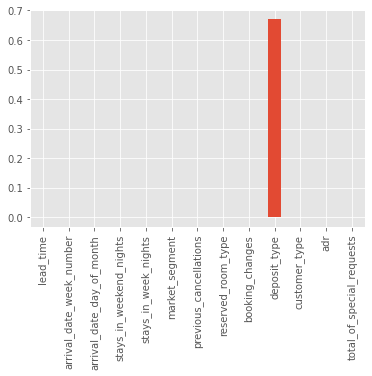

In [135]:
# Result of linear SVM weights
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=X_sample_train.columns)
weights.plot(kind='bar')

### Model 3 - Linear with C=100
- Model 1 with C=1 did not really bring out the weights of each feature well as shown in the barplot above. 
- By adjusting the C value to 100 to give it more tortuosity to the classification line, we expect to have a better weight distribution across features and accuracy.  

In [136]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=100, kernel='linear', random_state=10) # get object
svm_clf.fit(X_sample_train, y_sample_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7490995895803668
[[14999    44]
 [ 5947  2888]]


In [137]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.72      1.00      0.83     15043
           1       0.98      0.33      0.49      8835

    accuracy                           0.75     23878
   macro avg       0.85      0.66      0.66     23878
weighted avg       0.82      0.75      0.71     23878



In [138]:
# Describing support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(656, 13)
(656,)
[388 268]


[[ 1.00555544e-04 -4.66797433e-05  1.47199992e-05  2.84530011e-05
   9.47708622e-06  8.23649907e-05  2.42984081e-04 -6.11241585e-05
  -7.91153243e-05  6.69329648e-01 -4.16828985e-05  1.09629628e-04
  -1.16312110e-04]]


<AxesSubplot:>

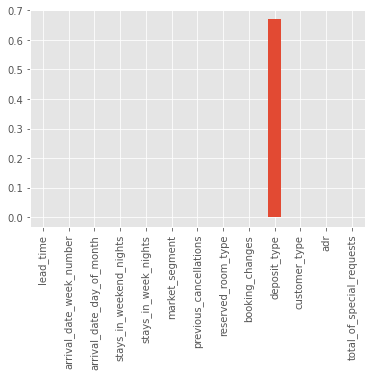

In [139]:
# Result of linear SVM weights
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=X_sample_train.columns)
weights.plot(kind='bar')

### Model 4 - Linear with C=1000

In [140]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=1000, kernel='linear', random_state=10) # get object
svm_clf.fit(X_sample_train, y_sample_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7490995895803668
[[14999    44]
 [ 5947  2888]]


In [141]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.72      1.00      0.83     15043
           1       0.98      0.33      0.49      8835

    accuracy                           0.75     23878
   macro avg       0.85      0.66      0.66     23878
weighted avg       0.82      0.75      0.71     23878



In [142]:
# Describing support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(493, 13)
(493,)
[256 237]


[[ 1.07020226e-03  2.63673801e-05  7.54076209e-05 -7.95345841e-05
   8.66690571e-05  1.00883744e-03  1.23372294e-03 -1.24534243e-04
  -1.20280767e-03  6.70400737e-01 -6.16597417e-05  8.49093754e-04
  -1.20006835e-03]]


<AxesSubplot:>

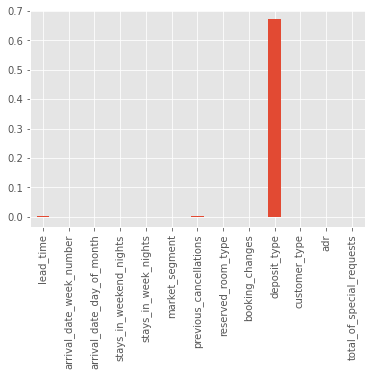

In [143]:
# Result of linear SVM weights
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=X_sample_train.columns)
weights.plot(kind='bar')

In [144]:
# Delving into relationship between SVM and original data

# Select the rows of the train indices and make df_tested_on dataframe
df_tested_on = X_sel.iloc[train_indices]

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy(deep=True)

df_support['is_canceled'] = y.loc[svm_clf.support_].copy(deep=True) # add back in the 'is_canceled' Column to the pandas dataframe

X_sel = X_sel.copy(deep=True)
X_sel['is_canceled'] = y # also add it back in for the original data
df_support=df_support.dropna()
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 369 to 415
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lead_time                  2 non-null      float64
 1   arrival_date_week_number   2 non-null      float64
 2   arrival_date_day_of_month  2 non-null      float64
 3   stays_in_weekend_nights    2 non-null      float64
 4   stays_in_week_nights       2 non-null      float64
 5   market_segment             2 non-null      float64
 6   previous_cancellations     2 non-null      float64
 7   reserved_room_type         2 non-null      float64
 8   booking_changes            2 non-null      float64
 9   deposit_type               2 non-null      float64
 10  customer_type              2 non-null      float64
 11  adr                        2 non-null      float64
 12  total_of_special_requests  2 non-null      float64
 13  is_canceled                2 non-null      float64

### `Do the chosen support vectors provide any insight into the data?`   <a id='question2'/> 

- The goal of SVM is to find the hyperplane in which the margin is maximized between the separated dataset. 
- Support vectors are the points closest to the hyperplane and gives us an idea on how separable the data is. 
- The linear SVM above did not show much difference in accuracy as well as weight distribution of the chosen features among different C values. More rigorous parameter changes can be conducted with non-linear RBF SVM and the results will be shared below for comparison. 

### So how can we fix this problem?<a id='question3'/> 
- We are going to experiment with the non-linear kernel SVM with adjusting different parameters. Depending on how much slack we allow the support vectors to enter the margin area, the number of support vectors can vary. The accuracy depends too on finding the right level of slack for the data. 
- Higher C is recommended as higher C results in a smaller margin so that we can minimize the number of misclassified support vectors with a high penalty. 
- Gamma of 0.1 is going to stay the same throughout the experiment to give it a baseline. 

### Result : 
- Gamma 0.1 and C of 1 resulted in the highest accuracy of 77%. 
- The accuracy got smaller with larger C values. 
- Through a numerous experiments with adjusting parameters, Gamma of 0.12 and C of 2 were the best parameter set to give us the best accuracy. 
- The following models show different accuracy distribution depending on a set pair of Gamma and C values. 

### Model 5 - RBF SVM with Gamma= 0.1, C=1

In [145]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=1)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_hat = rbf.predict(X_test)

In [146]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.74      0.98      0.84     15043
           1       0.92      0.41      0.57      8835

    accuracy                           0.77     23878
   macro avg       0.83      0.70      0.71     23878
weighted avg       0.81      0.77      0.74     23878



### Model 6 - RBF SVM with Gamma= 0.1, C=10

In [147]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=10)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_hat = rbf.predict(X_test)

In [148]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83     15043
           1       0.75      0.56      0.64      8835

    accuracy                           0.77     23878
   macro avg       0.76      0.72      0.73     23878
weighted avg       0.76      0.77      0.76     23878



### Model 7 - RBF SVM with Gamma= 0.1, C=100

In [149]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=100)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_hat = rbf.predict(X_test)

In [150]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     15043
           1       0.64      0.61      0.62      8835

    accuracy                           0.73     23878
   macro avg       0.71      0.70      0.71     23878
weighted avg       0.73      0.73      0.73     23878



### Model 8 - RBF SVM with Gamma= 0.1, C=1000

In [151]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=1000)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_hat = rbf.predict(X_test)

In [152]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77     15043
           1       0.60      0.63      0.61      8835

    accuracy                           0.71     23878
   macro avg       0.69      0.69      0.69     23878
weighted avg       0.71      0.71      0.71     23878



In [153]:
rbf.support_vectors_

array([[-0.21533638,  1.89891014,  1.61736638, ..., -3.70395736,
         0.17747652,  3.06338577],
       [ 0.27126956, -0.82066198,  0.36463211, ...,  1.49500965,
         0.43867863, -0.72069411],
       [-0.70194232, -0.82066198,  0.36463211, ..., -0.23797935,
        -0.19453862,  0.54066585],
       ...,
       [-0.18726296, -1.62918342, -1.68529671, ..., -0.23797935,
        -0.82775586, -0.72069411],
       [ 1.29127047,  0.72287896, -0.6603323 , ..., -0.23797935,
        -0.03029789, -0.72069411],
       [-0.93588749, -0.52665418, -0.09090763, ..., -0.23797935,
        -2.0150382 , -0.72069411]])

## Optimizating model - Stochastic Gradient Descent(SGD) Classifier

- Contrary to the conventional ML technique where we calculate the cost of all the data points after initializing the weights, SGD classifier calculates the cost of one single data point and the corresponding gradient. And this can process the data whole lot quicker. 

### Model 9 - Logistic regression using original data with SGD classifier
- This method explores logistic regression using the entire training dataset. 

- For the SGD Logistic classifier we were able to achieve __f1-score__ __not canceled (0)__ of __0.82__ and __canceled (1)__ of __0.66__. Our model is better at predicting __not canceled (0)__ than it is at predicting __canceled (1)__.
- Model had an __accuracy__ of __0.76__

In [154]:
from sklearn.linear_model import SGDClassifier
Logisitic_SGDclf = SGDClassifier(class_weight='balanced', alpha=.1, penalty='l2', loss='log', random_state=10)
from sklearn import metrics as mt

#train the model using the training sets
Logistic_SGD_fit = Logisitic_SGDclf.fit(X_train, y_train)
# predict the response for test dataset
Logistic_SGD_y_hat = Logisitic_SGDclf.predict(X_test)

Logistic_SGD_accuracy = mt.accuracy_score(y_test,Logistic_SGD_y_hat)
Logistic_SGD_conf = mt.confusion_matrix(y_test,Logistic_SGD_y_hat)

In [155]:
print('Accuracy:', Logistic_SGD_accuracy )
print('we got a classification rate of',Logistic_SGD_accuracy*100,'%')

Accuracy: 0.7607421057039954
we got a classification rate of 76.07421057039954 %


In [156]:
print(classification_report(y_test, Logistic_SGD_y_hat))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82     15043
           1       0.69      0.63      0.66      8835

    accuracy                           0.76     23878
   macro avg       0.74      0.73      0.74     23878
weighted avg       0.76      0.76      0.76     23878



### Model 10 - Linear SVM using original data with SGD classifier

- For the SGD Logistic classifier we were able to achieve __f1-score__ __not canceled (0)__ of __0.84__ and __canceled (1)__ of __0.63__. Our model is better at predicting __not canceled (0)__ than it is at predicting __canceled (1)__.
- Model had an __accuracy__ of __0.77__

In [157]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics as mt

SVM_SGDclf = SGDClassifier(class_weight='balanced', alpha=.1, penalty='l2', loss='hinge', random_state=10)

#train the model using the training sets
SVM_SGD_fit = SVM_SGDclf.fit(X_train, y_train)
# predict the response for test dataset
SVM_SGD_y_hat = SVM_SGDclf.predict(X_test)

SVM_SGD_accuracy = mt.accuracy_score(y_test, SVM_SGD_y_hat)
SVM_SGD_conf = mt.confusion_matrix(y_test, SVM_SGD_y_hat)

In [158]:
print('Accuracy:', SVM_SGD_accuracy)
print('we got a classification rate of',SVM_SGD_accuracy*100,'%')

Accuracy: 0.7730965742524499
we got a classification rate of 77.30965742524499 %


In [159]:
print(classification_report(y_test, SVM_SGD_y_hat))

              precision    recall  f1-score   support

           0       0.76      0.92      0.84     15043
           1       0.80      0.52      0.63      8835

    accuracy                           0.77     23878
   macro avg       0.78      0.72      0.73     23878
weighted avg       0.78      0.77      0.76     23878



# 2. Model Advantages<a id='Model-Advantages'/>

### General Pros and Cons of each model
For this lab we selected Logistic Regression and SVM as we are trying to predict classification data. The following lays out the pros and cons of each modeling used for this lab. The detailed explanation on how the models performed is discussed below. 

 - Logistic regression 
	- Advantage
		- Performs well when data is linearly separable. 
		- Provides model coefficients as indicators of feature importance. 
		
	- Disadvantages
		- Limited only to linear boundary
		- Bounded by the assumption of linearity between dependent features and independent features. 

 - SVM
	- Advantages
		- Provides good accuracy
		- Uses less memory. 
		- Offers clear margin of separation. 
	- Disadvantages 
		- Not ideal for large dataset due to high training time. 
        - Works poorly with highly correlated features and is very sensitive to the type of kernel used

### Does one type of model offer superior performance over another in terms of prediction accuracy?<a id='question4'/>  

- The following shows the best model chosen by each prediction metrics. 
    - Accuracy : __Model 1 - Logistic Regression with C=1__. 
    - Precision : __All linear SVM models__ performed the same. 
    - Recall : __Model 6 - RBF SVM with Gamma=0.1, C=10__. 
    - F1 score : __Model 10 - Linear SVM using SGD Classifier__. 

Below you'll the classification report for each of our models:

####  Model 1 - Logistic regression with C=1
    - Accuracy: 0.79
    - Precision
        - not canceled (0): 0.77
        - canceled (1): 0.85
    - Recall
        - not canceled (0): 0.94
        - canceled (1): 0.53
    - f1 score
        - not canceled (0): 0.85
        - canceled (1): 0.65

#### Model 2 - Linear SVM with C=1
    - Accuracy: 0.75
    - Precision
        - not canceled (0): 0.72
        - canceled (1): 0.98
    - Recall
        - not canceled (0): 1.00
        - canceled (1): 0.33
    - f1 score
        - not canceled (0): 0.83
        - canceled (1):  0.49

#### Model 3 - Linear SVM with C=100
    - Accuracy: 0.75
    - Pression
        - not canceled (0): 0.72
        - canceled (1): 0.98
    - Recall
        - not canceled (0): 1.00
        - canceled (1): 0.33
    - f1 score
        - not canceled (0): 0.83
        - canceled (1):  0.49
 
#### Model 4 - Linear SVM with C=1000
    - Accuracy: 0.75
    - Precision
        - not canceled (0): 0.72
        - canceled (1): 0.98
    - Recall
        - not canceled (0): 1.00
        - canceled (1): 0.33
    - f1 score
        - not canceled (0): 0.83
        - canceled (1): 0.49
        
#### Model 5 - RBF SVM with Gamma=0.1, C=1
    - Accuracy: 0.77
    - Precision
        - not canceled (0): 0.74
        - canceled (1): 0.92
    - Recall
        - not canceled (0): 0.98
        - canceled (1): 0.41
    - f1 score
        - not canceled (0): 0.84
        - canceled (1): 0.57

#### Model 6 - RBF SVM with Gamma=0.1, C=10
    - Accuracy: 0.77
    - Precision
        - not canceled (0): 0.77
        - canceled (1): 0.75
    - Recall
        - not canceled (0): 0.89
        - canceled (1): 0.56
    - f1 score
        - not canceled (0): 0.83
        - canceled (1): 0.64

#### Model 7 - RBF SVM with Gamma=0.1, C=100
    - Accuracy: 0.73
    - Precision
        - not canceled (0): 0.78
        - canceled (1): 0.64
    - Recall
        - not canceled (0): 0.80
        - canceled (1): 0.61
    - f1 score
        - not canceled (0): 0.79
        - canceled (1): 0.62

#### Model 8 - RBF SVM with Gamma=0.1, C=1000
    - Accuracy: 0.71
    - Precision
        - not canceled (0): 0.77
        - canceled (1): 0.60
    - Recall
        - not canceled (0): 0.76
        - canceled (1): 0.63
    - f1 score
        - not canceled (0): 0.77
        - canceled (1): 0.61
        
#### Model 8 - RBF SVM with Gamma=0.1, C=1000
    - Accuracy: 0.71
    - Precision
        - not canceled (0): 0.77
        - canceled (1): 0.60
    - Recall
        - not canceled (0): 0.76
        - canceled (1): 0.63
    - f1 score
        - not canceled (0): 0.77
        - canceled (1): 0.61

#### Model 9 - Logistic regression using SGD Classifier
    - Accuracy: 0.76
    - Precision
        - not canceled (0): 0.79
        - canceled (1): 0.69
    - Recall
        - not canceled (0): 0.84
        - canceled (1): 0.63
    - f1 score
        - not canceled (0): 0.82
        - canceled (1): 0.66

#### Model 10 - Linear SVM using SGD Classifier
    - Accuracy: 0.77
    - Precision
        - not canceled (0): 0.76
        - canceled (1): 0.80
    - Recall
        - not canceled (0): 0.92
        - canceled (1): 0.52
    - f1 score
        - not canceled (0): 0.84
        - canceled (1): 0.63

### In terms of training time or efficiency?  <a id='question5'/> 

#### Logistic regression 
- It took about 5 seconds to process the data with LogisticRegression Classifier.

#### Linear SVM
- It took about 10 hours to run with the original data. 
- Had to downsample and utilize only 1% of the original data. It took about 5 mins with downsample data. 
- The processing time incrementally increased with larger C values. 

#### Non-linear SVM
- It took about 3 seconds to process the downsample data. 

#### Stochastic Gradient Descent
- It took about 3.2 seconds to process the data with __logistic regression__ loss function
- It took about 2.4 seconds to process the data with __linear SVM__ loss function

### Conclusion : Best Model for efficiency and Accuracy
- When taking both the computation performance and accuracy into account, **SDG Classifier with logistic regression** had the best performance. 

# 3. Interpret Feature Importance<a id='Interpret-Feature-Importance'/>

## Interpreting weights for Logistic Regression

### `Given the coefficients of each feature, why do you think some features are more important?` <a id='question1'/> 

Below is a list of coefficients for our best logistic regression model that we used after selecting for feature importance. We have already __scaled__ all of our data, which means we can interpret in the importance of each of the coefficients in this model: 

In [160]:
# iterate over the coefficients
weights = logreg.coef_.T # take transpose to make a column vector
variable_names = X_train.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
df = pd.DataFrame({
    'cols': variable_names.tolist(),
    'weights': weights.ravel().tolist()
})    

print('\n')

print(df.sort_values(by=['weights']))  

lead_time has weight of 0.35727102646627423
arrival_date_week_number has weight of -0.05892306414588878
arrival_date_day_of_month has weight of 0.001303153061961387
stays_in_weekend_nights has weight of 0.03517171762429862
stays_in_week_nights has weight of 0.06846085701611163
market_segment has weight of 0.5444193010654117
previous_cancellations has weight of 1.3683286068513687
reserved_room_type has weight of -0.013096610688520473
booking_changes has weight of -0.29124012715963343
deposit_type has weight of 1.421851970529543
customer_type has weight of -0.034732778750654995
adr has weight of 0.3033273758669316
total_of_special_requests has weight of -0.510200137826707


                         cols   weights
12  total_of_special_requests -0.510200
8             booking_changes -0.291240
1    arrival_date_week_number -0.058923
10              customer_type -0.034733
7          reserved_room_type -0.013097
2   arrival_date_day_of_month  0.001303
3     stays_in_weekend_nights  0.035172

Below you'll see a graph of the __coefficients__, and you'll notice that the attributes that have the most positive impact in order are: 
- __Deposit_type__, __previous_cancellations__, __market_segment__, __lead_time__,__adr__, __stays_in_week_nights__, __stays_in_weekend_nights__,__arrival_date_day_of_month__

Also the attributes with the most negative impact in order are:   
- __total_of_special_requests__,__booking_changes__, __arrival_date_week_number__, __customer_type__, __reserved_room_type__ .


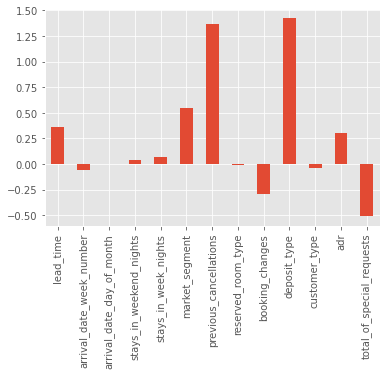

In [161]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(logreg.coef_[0],index=X_train.columns)
weights.plot(kind='bar')
plt.show()

#### Positive importance

- The __intercept__ is __-0.10307943__ which corresponds to the log odds for hotel booking being canceled
- Most important feature, __deposit_type__, is a categorical variable and it has __coefficient__ of __1.421852__ which gives odd ratio of __4.144789487__.
    - For every 1 unit increase in deposit type (0 = No Deposit, 1 = Non Refund, 2 = Refundable), the odds will increase by a multiplicative factor of 4.144789487 holding all other features employed in the model fixed.
- Second important feature, __previous_cancellation__, is a categorical variable and it has __coefficient__ of __1.368329__ which gives odd ratio of __3.928780216__.
    - For every 1 unit increase  in lead_time, the odds will increase by a multiplicative factor of 3.928780216 holding all other features employed in the model fixed.
- __market_segment__ is a categorical variable and it has __coefficient__ of __0.544419__ which gives odd ratio of __1.723606676__.
    - For every 1 unit increase  in market_segment (0 = 'Aviation', 1 = 'Complementary', 2 = 'Corporate', 3 = 'Direct', 4 = 'Groups', 5 = 'Online TA', 6 = 'Offline TA/TO'), the odds will increase by a multiplicative factor of 1.723606676 holding all other features employed in the model fixed.
- __lead_time__ is a continuous variable and it has __coefficient__ of __0.3572__ which gives odd ratio of __1.429321706__.
    - For every 1 unit increase  in lead_time, the odds will increase by a multiplicative factor of 1.429321706 holding all other features employed in the model fixed.
- __adr__ is a continuous variable and it has __coefficient__ of __0.303327__ which gives odd ratio of __1.354357267__.
    - For every 1 unit increase  in adr, the odds will increase by a multiplicative factor of 1.354357267 holding all other features employed in the model fixed.
- __stays_in_week_nights__ is a continuous variable and it has __coefficient__ of __0.068461__ which gives odd ratio of __1.070858861__.
    - For every 1 unit increase  in stays_week_nights, the odds will increase by a multiplicative factor of 1.070858861 holding all other features employed in the model fixed.
- __stays_in_weekend_nights__ is a continuous variable and it has __coefficient__ of __0.035172__ which gives odd ratio of __1.035797851__.
    - For every 1 unit increase  in stays_in_weekend_nights, the odds will increase by a multiplicative factor of 1.035797851 holding all other features employed in the model fixed.
- __arrival_date_day_of_month__ is a categorical variable and it has __coefficient__ of __0.001303__ which gives odd ratio of __1.001303849__.
    - For every 1 unit increase  in arrival_date_day_of_month, the odds will increase by a multiplicative factor of 1.001303849 holding all other features employed in the model fixed.
    
    

#### Negative importance 

- __reserved_room_type__ is a categorical variable and it has __coefficient__ of __-0.013097__ which gives odd ratio of __0.986988393__.
    - For every 1 unit increase  in reserved_room_type, the odds will decrease by a multiplicative factor of 0.986988393 holding all other features employed in the model fixed.
- __customer_type__ is a categorical variable and it has __coefficient__ of __-0.034733__ which gives odd ratio of __0.965863267__.
    - For every 1 unit increase  in customer_type(0: 'Contract',1:'Group',2:'Transient', 3:'Transient-Party'), the odds will decrease by a multiplicative factor of 0.965863267 holding all other features employed in the model fixed.
- __arrival_date_week_number__ is a continuous variable and it has __coefficient__ of __-0.058923__ which gives odd ratio of __0.94277936__.
    - For every 1 unit increase  in arrival_date_week_number, the odds will decrease by a multiplicative factor of 0.94277936 holding all other features employed in the model fixed.
- __booking_changes__ is a continuous variable and it has __coefficient__ of __-0.29124__ which gives odd ratio of __0.747336296__.
    - For every 1 unit increase  in booking_changes, the odds will decrease by a multiplicative factor of 0.747336296 holding all other features employed in the model fixed.
- __total_of_special_requests__ is a continuous variable and it has __coefficient__ of __-0.5102__ which gives odd ratio of __0.600375492__.
    - For every 1 unit increase  in total_of_special_requests, the odds will decrease by a multiplicative factor of 0.600375492 holding all other features employed in the model fixed.


# 4. Interpret Support Vectors<a id='Interpret-Support-Vectors'/>

#### Here in the following graphs (original data vs support vectors), we notice that support vector's 'is_canceled' binary graph is closely more overlapping with one another than the original data.  That is simply expected due to the support vectors being on the edge of the class boundaries.  The following list of selected features is ranked in the order of the classification performance  based on the graphical appearance (based on how much overlapping the 'is_canceled' graph lines are). 

#### Although the general performance trend is very similar to the weight distribution from the logistic regression and svm result, the features that were highly ranked in the weight distribution were not necessarily the ones with the support vectors that were tracking the original data as well. 


- __previous_cancellations__ , __deposit_type__ have outperformed other features as expected. Their support vector graphs are closely matching with the original data and also their classifications are closely overlapping with one another. 
- __booking_changes__, __total_of_special_requests__, __customer_type__, __lead_time__, __market_segment__,__stays_in_weekend_nights__, __reserved_room_type__, and __stays_in_week_nights__ support vectors have done decent jobs in tracking the original data.  
- __arrival_date_day_of_month__ , __arrival_date_week_number__, and __adr__ shows the most variations between the support vectors and original data even though it is relatively ranked high in the weight performance result from the SVM linear. 



In [162]:
# Loading linear SVM using original dataset

from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=1.0, kernel='linear', random_state=10) # get object
svm_clf.fit(X_train, y_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions


# Delving into relationship between SVM and original data

# Select the rows of the train indices and make df_tested_on dataframe
df_tested_on = X_sel.iloc[train_indices]

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy(deep=True)

df_support['is_canceled'] = y.loc[svm_clf.support_].copy(deep=True) # add back in the 'is_canceled' Column to the pandas dataframe

X_sel = X_sel.copy(deep=True)
X_sel['is_canceled'] = y # also add it back in for the original data
df_support=df_support.dropna()
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19693 entries, 79586 to 73376
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lead_time                  19693 non-null  float64
 1   arrival_date_week_number   19693 non-null  float64
 2   arrival_date_day_of_month  19693 non-null  float64
 3   stays_in_weekend_nights    19693 non-null  float64
 4   stays_in_week_nights       19693 non-null  float64
 5   market_segment             19693 non-null  float64
 6   previous_cancellations     19693 non-null  float64
 7   reserved_room_type         19693 non-null  float64
 8   booking_changes            19693 non-null  float64
 9   deposit_type               19693 non-null  float64
 10  customer_type              19693 non-null  float64
 11  adr                        19693 non-null  float64
 12  total_of_special_requests  19693 non-null  float64
 13  is_canceled                19693 non-null 

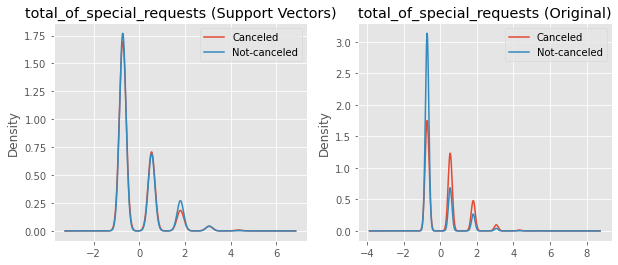

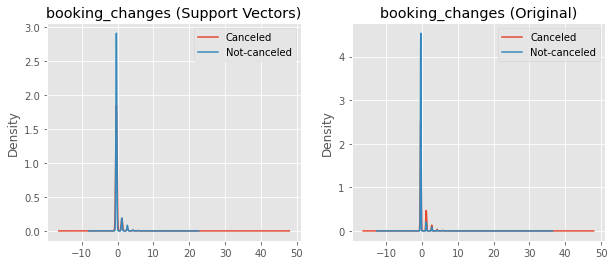

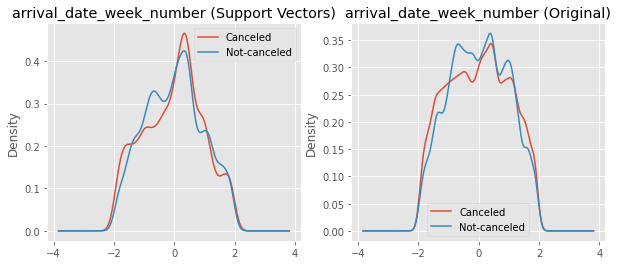

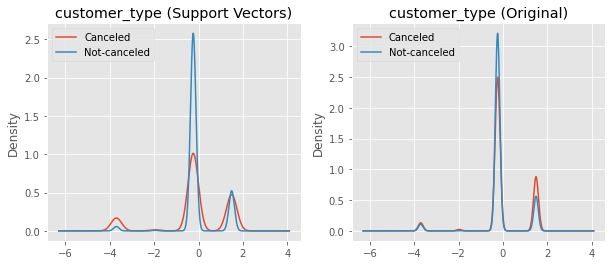

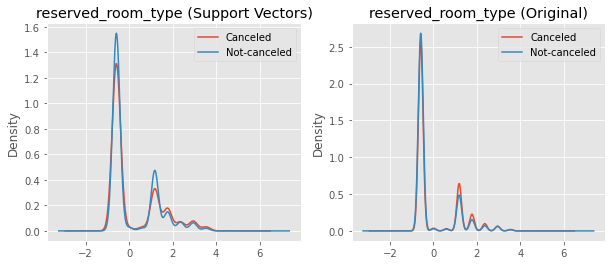

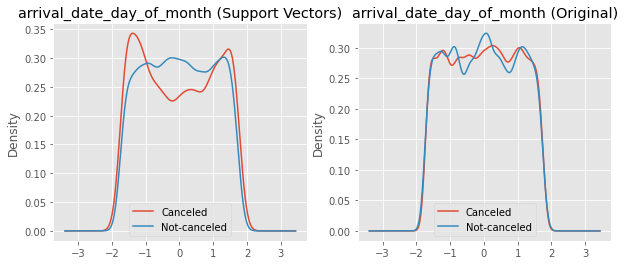

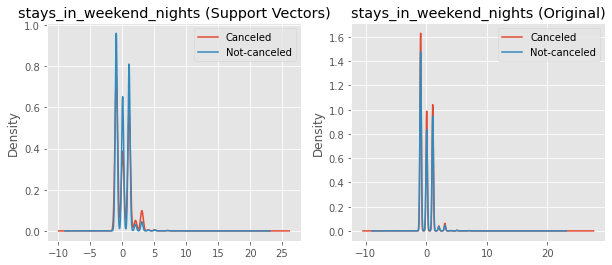

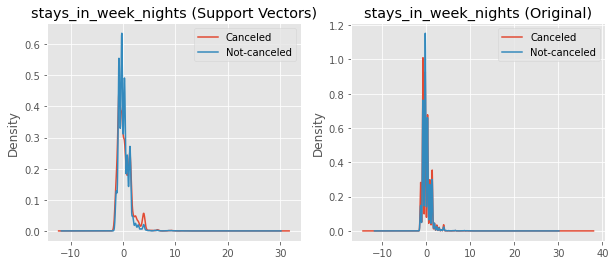

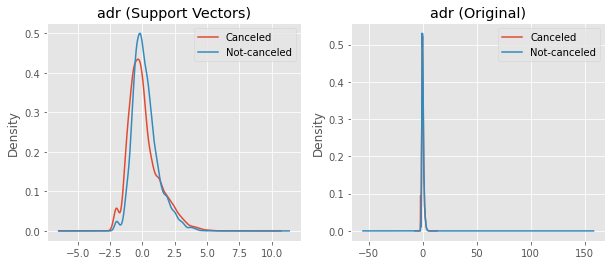

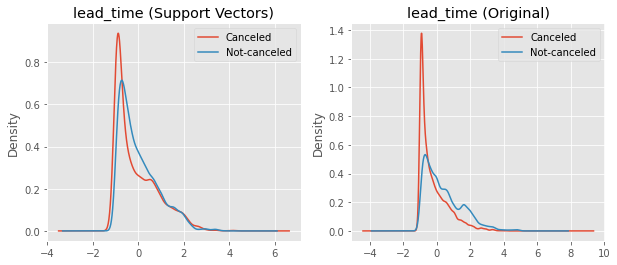

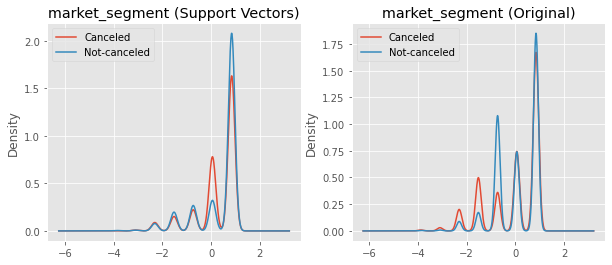

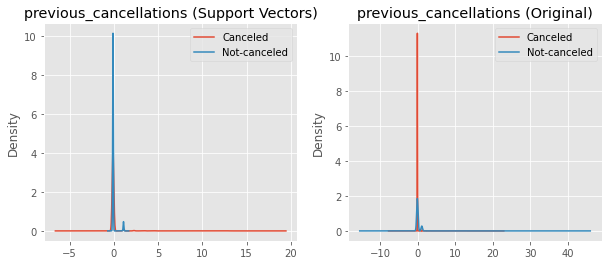

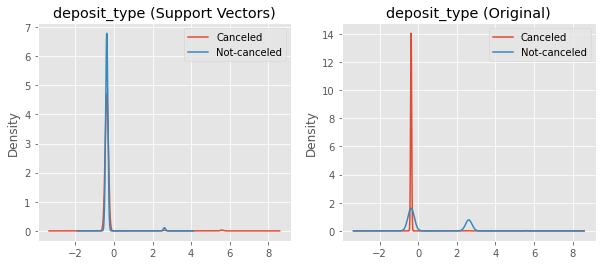

In [163]:
import pandas
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['is_canceled'])
df_grouped = X_sel.groupby(['is_canceled'])

# plot KDE of Different variables
vars_to_plot = ['total_of_special_requests','booking_changes','arrival_date_week_number','customer_type','reserved_room_type','arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights','adr','lead_time','market_segment','previous_cancellations','deposit_type']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Canceled','Not-canceled'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Canceled','Not-canceled'])
    plt.title(v+' (Original)')